In [1]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy import fftpack as ft

In [2]:
class Bloc8x8: #Classe sur un bloc  8 par 8
    def __init__(self, nom, matrice):  
        self.nom = nom 
        self.contenu = matrice #Bloc 8x8 avec lequel on travaille type np.array
        self.valide=True
        self.comp = [] # image compilée
        self.DCT = np.array([])
        self.line = [] 
        self.RLE=[]        
        
    def test(self):
        print("Nom: ", self.nom, "type: ", type(self.nom))
        print("Contenu: ", self.contenu, "type: ", type(self.contenu))
        print("Valide: ", self.valide) 
        print("Compilation: ", self.comp, "type: ", type(self.comp))
        print("DCT: ", self.DCT, "type: ", type(self.DCT))
        print("Line: ", self.line, "type: ", type(self.line))
        print("RLE: ", self.RLE, "type: ", type(self.RLE))
    
    
    def check_matrice(self): #Vérifie la validité des données
        if self.contenu.shape != (8,8) :
            self.valide = False
            print("error")
        for i in range(0,8):
             for j in range(0,8):
                if self.contenu[i,j]> 255 or self.contenu[i,j]<0:
                    self.valide = False
                    print("error")
                    
    def show(self, trans): #Représente l'image, trans permet de choisir si on veut l'image comprimée ou pas
        self.check_matrice()
        if self.valide:
            if trans==True:
                plt.figure(figsize=(8, 8))
                #Afficher deux images côte à côte, format:(row,column,1er/2e image)
                plt.subplot(1,2,1) 
                plt.imshow(self.contenu, cmap="gray", vmin=0, vmax=255)
                plt.colorbar(label="Intensity (0-255)", fraction = 0.046)
                plt.title("Image originale " +self.nom)
                plt.axis("off")
                
                plt.subplot(1,2,2)
                plt.imshow(self.comp, cmap="gray", vmin=0, vmax=255)
                plt.colorbar(label="Intensity (0-255)", fraction = 0.046)
                plt.title("Image compressée " +self.nom)
                plt.axis("off")
            else:
                #plt.figure(figsize=(D, D))
                #plt.imshow(self.contenu, cmap="gray", vmin=0, vmax=255)
                #plt.colorbar(label="Intensity (0-255)", fraction = 0.046)
                #plt.title("Visualisation image " +self.nom)
                #plt.axis("off")
                pass           
            plt.tight_layout()
            plt.show()
            return self
        else:
            print("Matrice sous un mauvais format")
            
            
    def calcul(self,Q):
        self.DCT = ft.dct(ft.dct(self.contenu.T, norm='ortho').T,norm='ortho')
        self.DCT = np.round(self.DCT/Q).astype(int)
        return self.DCT
  
    def zigzag(self):
        # M np.array de de dimension d*d
        sgn=1 #sens de parcours de la diagonale
        back=False #mot-clef début de la seconde moitié de la matrice
        for sum in range(2*8 -1):
            #itération sur la somme de i abscisse et j ordonnée de chaque coefficient de M ie les diagonales de M
            if sum==8:
                back=True
            #détermination de la liste des abscisses des coefficients de la diagonale à parcourir
            if sgn==-1:
                if not back:
                    R=range(sum+1)
                else:
                    R=range(sum-8+1,8)
            else:
                if not back:
                    R=range(sum,-1,-1)
                else:
                    R=range(8-1,sum-8,-1)
            for i in R:
                self.line.append(self.DCT[i,sum-i]) #i+j=sum donc j=sum-i
            sgn=-sgn
        return self.line
    
    
    def RLE(self):
        k=-1 #marqueur initial k
        cpt=0
        print(type(self.line))
        for i in self.line: 
            if i==0:
                # cas initial (cas premier 0) pour i = 0: on crée la liste des 0
                if k!=0:
                    self.RLE.append([0,1])
                    cpt+=1
                # 0 suivants
                else:
                    self.RLE[cpt-1]=[0,self.RLE[cpt-1][1]+1]
            # cas différent de 0
            else:
                self.RLE.append(i)
                cpt+=1
            k=i
        return self
    
    
    def inverse_calcul(self,Q):
        self.dequantifier = self.DCT*Q
        self.comp = ft.idct(ft.idct(self.dequantifier.T, norm='ortho').T,norm='ortho')
        return self.comp
  
    def score(self):
        self.erreur=(np.sum(abs(self.comp-self.contenu))/64)
        self.compression=(len(self.RLE)/64)*100
        print("L'erreur moyenne des pixels pour l'image",self.nom,"est :",self.erreur," unité(s)\n Son taux de compression est :",self.compression, "%")
        return self
    
    def compress(self,Q): #Fait les étapes une par une jusqu'à la compression
        self.show(False)
        self.calcul(Q)
        self.zigzag()
        return self

    def decompress(self,Q): #Fait les étapes de décompression
        self.inverse_calcul(Q)
        self.show(True)
        return self

In [12]:
class Image:
    def __init__(self, nom, matrice):
        self.nom = nom
        self.contenu = np.array(matrice) #matrice de l'image
        self.lenx = len(matrice[0]) #longueur
        self.leny = len(matrice) #hauteur
        self.blocs = [] #liste des blocs 8x8 de l'image
        
    def division(self):
        y=0
        cpt=1
        while y+8<=self.leny:
            x=0
            while x+8<=self.lenx:
                self.blocs.append(Bloc8x8(str(cpt),self.contenu[y:y+8,x:x+8]))
                cpt+=1
                x+=8
            if x!=self.lenx:
                L=[list(self.contenu[z,x:self.lenx])+[self.contenu[z,self.lenx-1] for i in range(8-(self.lenx-x))] for z in range(y,y+8)]
                self.blocs.append(Bloc8x8(str(cpt),np.array(L)))
                cpt+=1
            y+=8
        if y!=self.leny:
            x=0
            while x+8<=self.lenx:
                L=[list(self.contenu[z,x:x+8]) for z in range(y,self.leny)]+[list(self.contenu[self.leny-1,x:x+8]) for z in range(8-(self.leny-y))]
                self.blocs.append(Bloc8x8(str(cpt),np.array(L)))
                cpt+=1
                x+=8
            if x!=self.lenx:
                L=[]
                for z in range (y,self.leny):
                    L.append(list(self.contenu[z,x:self.lenx])+[self.contenu[z,self.lenx-1] for i in range(8-(self.lenx-x))])
                L=L+[L[-1] for z in range(8-(self.leny-y))]
                self.blocs.append(Bloc8x8(str(cpt),np.array(L)))           

    def compressI(self,Q):
        for b in self.blocs:
            b.compress(Q)
    
    def decompressI(self,Q):
        for b in self.blocs:
            b.decompress(Q)

In [4]:
#Huffman adapté de https://gist.github.com/GautierLePire/ee104b066f184f9c62bc89e87e494c06 par gaultier LePire
def compterOccurences(liste):
    """
    Renvoie une liste qui associe à chaque caractère son nombre d'apparitions.
    Chaque lettre est donc dottée d'un poids (son nombre d'occurences), et
    plus son poids est élevé, plus elle sera légère en mémoire.
    (L'objectif étant ici la compression, donc d'échanger de la puissance
    de calcul contre de l'espace de stockage.)
    """
    lettres={}
    for i in liste:
        j=i
        if type(i)==list:
            j="$"+str(i[1])
        if j in lettres :
            lettres[j]+=1
        else:
            lettres[j]=1
    alphabet=[]
    for i in lettres:
        alphabet.append([lettres[i],i])
    return alphabet
def creerArbre(alphabet):
    """
    Crée un arbre binaire à partir des lettres et de leur poids.
    On choisit de représenter un arbre de la façon suivante :
      * Une feuille est un 2-uplet : le nombre d'occurences et la lettre
        On notera que compterOccurences renvoie en fait une liste de feuilles.
      * Un noeud est un 3-uplet : la somme des occurences de toutes
        les feuilles descendantes, le fils gauche et le fils droit.
    Ensuite, on construit l'arbre en piochant les deux noeuds de poids
    le plus faible, on en fait un nouveau noeud que l'on remet dans le tas.
    On s'arrête dès qu'il reste un unique noeud (qui est l'arbre voulu)
    """
    # On commence par enlever les lettres qui ne sont pas présentes
    noeuds = alphabet
    # Puis on récupère les deux noeuds (ou feuilles) de poids le plus faible,
    # et on en fait un noeud, de poids la somme des deux petits poids
    # On boucle tant qu'il y a reste au moins deux noeuds
    l = len(noeuds)
    while l >= 2:
        # Indice et noeud des minima des poids
        # (on initialise avec les deux premières valeurs)
        petitMin = (0, noeuds[0])
        grandMin = (1, noeuds[1])
        for i in range(2, l):
            if noeuds[i][0] <= petitMin[1][0]:  # poids < petitMin < grandMin
                grandMin = petitMin
                petitMin = (i, noeuds[i])
            elif noeuds[i][0] <= grandMin[1][0]:  # petitMin < poids < grandMin
                grandMin = (i, noeuds[i])
        nouveauNoeud = (
            petitMin[1][0] + grandMin[1][0],
            noeuds[petitMin[0]],
            noeuds[grandMin[0]]
        )
        # On enlève les deux noeuds (ou feuilles) précedentes
        # et on ajoute le nouveau noeud
        noeuds[petitMin[0]] = nouveauNoeud
        noeuds.pop(grandMin[0])
        # On a au final un noeud de moins (-2 +1)
        l -= 1
    # À cet instant il ne reste plus qu'un noeud, qui est la racine de
    # l'arbre de Huffman
    return noeuds[0]

"""
On remarquera que moins une lettre est présente, plus elle est profonde dans l'arbre.
L'idée maintenant va être d'attribuer à chaque lettre un code en binaire de la façon
suivante :
  * la longueur du code est égale à la profondeur dans l'arbre
  * pour chaque lettre (donc chaque feuille), on part de la racine et on ajoute un 0
    si on prend la branche de gauche, un 1 si on passe par celle de droite.
Ainsi, plus une lettre est fréquente, plus son code binaire est court.
"""


def creerDico(arbre):
    """
    Renvoie un dictionnaire {lettre: code binaire}.
    On va explorer l'arbre à l'aide d'une file : si on rencontre une feuille,
    on la traite, si on rencontre un noeud, on ajoute les deux branches à la file.
    Le premier composant d'un élément de la file est le code binaire jusqu'à cet élément,
    le second est un noeud ou une feuille.
    """
    fileExploration = [("", arbre)]
    dico = {}
    l = 1
    # On boucle tant que la file n'est pas vide
    while l >= 1:
        code, truc = fileExploration.pop(0)  # On défile le premier élément
        l -= 1
        if len(truc) == 2:  # C'est une feuille
            dico[truc[1]] = code  # On ajoute la lettre et son code au dico
        elif len(truc) == 3:  # C'est un noeud
            # On continue l'exploration en respectant la règle pour obtenir le code :
            # Gauche -> 0, droite -> 1
            fileExploration.append((code + "0", truc[1]))
            fileExploration.append((code + "1", truc[2]))
            l += 2

    return dico


def huffman(liste):
    """
    On se contente de remplacer les lettres du texte par le code binaire
    obtenu à l'aide de la fonction creerDico.
    """
    alphabet = compterOccurences(liste)
    arbre = creerArbre(alphabet)
    dico = creerDico(arbre)
    texteCompresse = ""
    for i in liste:
        if type(i)==list:
            texteCompresse += dico["$"+str(i[1])]
        else:
            texteCompresse += dico[i]
    # On n'oublie pas de renvoyer aussi le dictionnaire,
    # sinon il sera impossible de décompresser le texte
    return texteCompresse, dico

def huffman_inverse(texteCompresse, dicoRetourne):
    """
    Décompresse un texte à l'aide de son dico.
    Une fois encore, on utilise une file. C'est un outil très puissant
    qui permet de ne jamais écrire de fonction récursive. Chaque élément
    de la file est un 2-uplet, le premier élément est le texte décompressé
    jusque là, le second est le code binaire restant à décompresser.
    """
    # On retourne le dico
    dico = {v: k for (k, v) in dicoRetourne.items()}
    # Nombre maximum de bits d'un caractère compressé
    limite = max(len(k) for k in dico.keys())
    fileExploration = [("", texteCompresse)]
    l = 1
    a=[]
    while l >= 1:
        fait, restant = fileExploration.pop(0)  # On défile le premier élément
        l -= 1
        # On regarde si la décompression est terminée
        if restant == "":
            return a
        # Sinon, on tente de remplacer les i premiers bits de restant par un caractère
        i = 0
        bits = ""
        #print(fait,restant)
        for bit in restant:
            bits += bit
            i += 1
            if i > limite:
                # C'est pas la peine de continuer, bits est trop long
                # pour correspondre à un caractère
                break
            elif bits in dico:
                # On a la possibilité de remplacer quelques 0 et 1 par un caractère
                # alors on le fait, sans pour autant considérer que l'on a choisi
                # le bon remplacement
                if type(dico[bits])==str:
                    a.append([0,int(dico[bits][1])])
                else:
                    a.append(dico[bits])
                print(a)
                fileExploration.append((fait+str(dico[bits]), restant[i:]))
                l += 1
                
                # Puis on continue à explorer les possibilités
    # Aucune décompression n'a fonctionné, on ne renvoie rien
    return None

#Exemple huffman
liste =[1,1,1,1,2,3,4,5,[0,5]]
# On le compresse
texteCompresse, dico = huffman(liste)
print(texteCompresse,dico)
print("Avant : {} bits / Après : {} bits, Taux de compression: {}".format(len(liste) * 8, len(texteCompresse),len(texteCompresse)/(len(liste) * 8)))
if liste ==  huffman_inverse(texteCompresse, dico):
    print("La décompression a fonctionné")

1111111101011101010011000 {2: '0', 1: '11', '$5': '1000', 5: '1001', 4: '1010', 3: '1011'}
Avant : 72 bits / Après : 25 bits, Taux de compression: 0.3472222222222222
[1]
[1, 1]
[1, 1, 1]
[1, 1, 1, 1]
[1, 1, 1, 1, 2]
[1, 1, 1, 1, 2, 3]
[1, 1, 1, 1, 2, 3, 4]
[1, 1, 1, 1, 2, 3, 4, 5]
[1, 1, 1, 1, 2, 3, 4, 5, [0, 5]]
La décompression a fonctionné


In [11]:
#Quantization Matrix from https://hal.science/hal-03858141/file/qtable.pdf
#Quantification minimale
Q1=[1,1,1,1,1,2,2,2,1,1,1,1,1,2,2,2,1,1,1,1,2,2,3,2,1,1,1,1,2,3,3,2,1,1,1,2,3,4,4,3,1,1,2,3,3,4,5,4,2,3,3,3,4,5,5,4,3,4,4,4,4,4,4,4]
#Quantification intermédiaire
Q2=[1,2,2,3,5,8,10,12,2,2,3,4,5,12,12,11,3,3,3,5,8,11,14,11,3,3,4,6,10,17,16,12,4,4,7,11,14,22,21,15,5,7,11,13,16,21,23,18,10,13,16,17,21,24,24,20,14,18,19,20,22,20,21,20]
#Quantification importante
Q3=[1,9,8,13,19,32,41,49,10,10,11,15,21,46,48,255,11,10,13,19,32,46,55,45,11,14,18,23,41,255,255,255,14,18,30,45,54,255,255,255,19,28,44,51,255,255,255,255,39,51,62,255,255,255,255,255,58,255,255,255,255,255,255,255]
print(len(Q3))
Q1=np.array(Q1)
Q1=Q1.reshape((8,8))
Q2=np.array(Q2)
Q2=Q2.reshape((8,8))
Q3=np.array(Q3)
Q3=Q3.reshape((8,8))


64


8
9
8
8
[[205 200 195 190 185 180 175 170]
 [205 200 195 190 185 180 175 170]
 [205 200 195 190 185 180 175 170]
 [205 200 195 190 185 180 175 170]
 [205 200 195 190 185 180 175 170]
 [205 200 195 190 185 180 175 170]
 [205 200 195 190 185 180 175 170]
 [205 200 195 190 185 180 175 170]]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

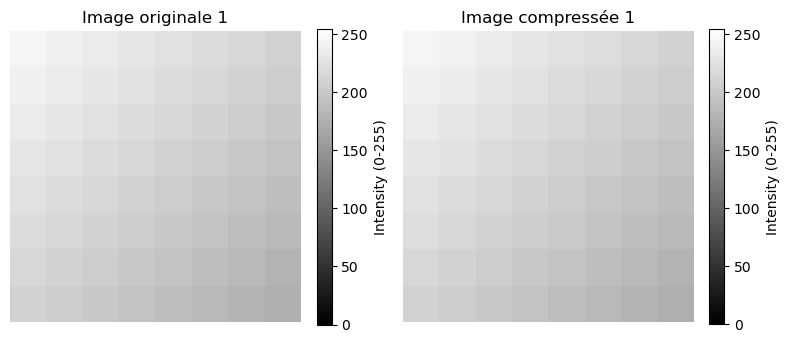

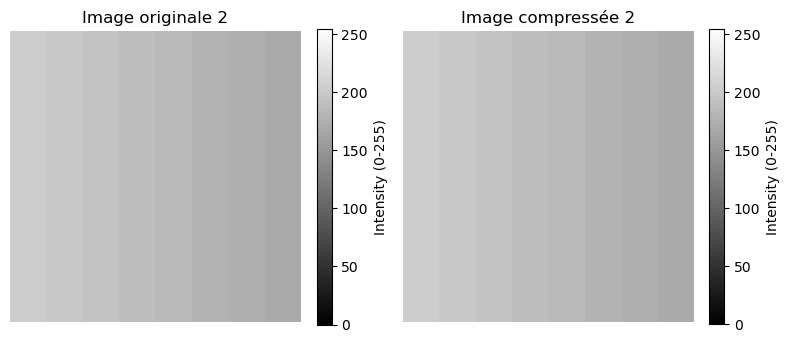

<Figure size 640x480 with 0 Axes>

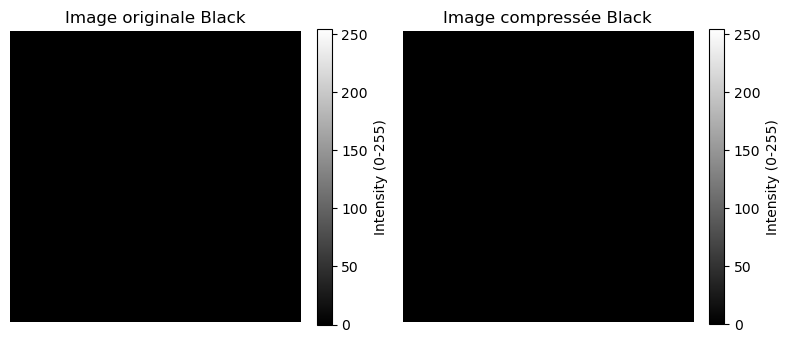

<Figure size 640x480 with 0 Axes>

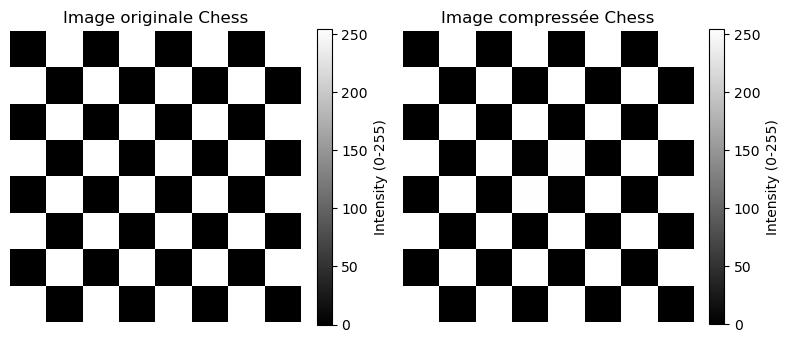

<Figure size 640x480 with 0 Axes>

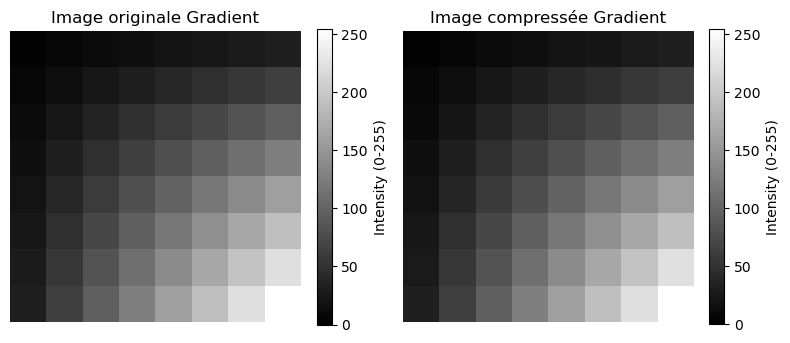

<Figure size 640x480 with 0 Axes>

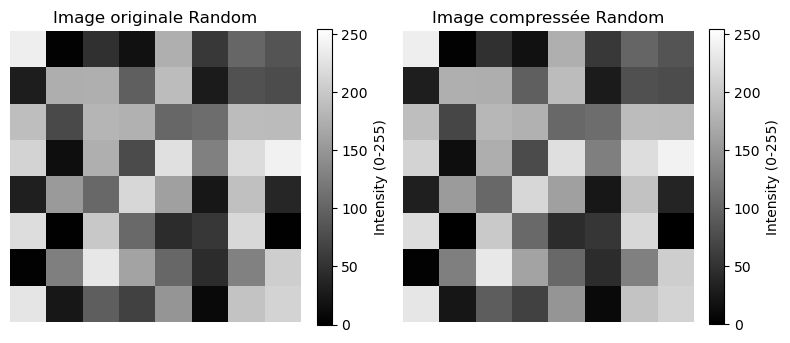

In [9]:
#Génération d'images test entièrement noire, en damier noir/blanc, avec un gradient fort avec un gradient plus faible, au hasard
B=[[0]*8]*8 

C=[]
for i in range(1,9):
    C.append([])
    for j in range(1,9):
        C[i-1].append(((i+j)%2)*255)
G=[]
for i in range(1,9):
    G.append([])
    for j in range(1,9):
        G[i-1].append(4*i*j-1)
S=[]
for i in range(1,10):
    S.append([])
    for j in range(1,10):
        S[i-1].append(255-(i+j)*5)     
R=[]
for i in range(1,9):
    R.append([])
    for j in range(1,9):
        R[i-1].append(random.randint(0,255))


#Test des images test
Test=Image("Standard",np.array(S))
Test.division()
Test.compressI(Q1)
Test.decompressI(Q1)
Bloc8x8("Black",np.array(B)).compress(Q1).decompress(Q1)
Bloc8x8("Chess",np.array(C)).compress(Q1).decompress(Q1)
Bloc8x8("Gradient",np.array(G)).compress(Q1).decompress(Q1)
Bloc8x8("Random",np.array(R)).compress(Q1).decompress(Q1)